In [38]:
import os,sys,inspect
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0,parentdir) 

from importlib import reload 
import torch
import fasttext
from ptb import lang_util
import torch
from torch.nn import CrossEntropyLoss, NLLLoss
import numpy as np
import matplotlib.pyplot as plt
import numpy as np



In [2]:
NTA = '/Users/jgordon/nta'

In [3]:
corpus = lang_util.Corpus(NTA + '/datasets/PTB')

## Maybe load KN5 model

In [4]:
kn5 = np.load(NTA + '/datasets/PTB/KN5/kn5D_predictions_82430-089-w.npy')

In [19]:
word2id = {}
remap = np.zeros(10000, dtype=int)
with open(NTA + '/datasets/PTB/KN5/ptb_dense_inc_mar8.txt') as f:
    i = 0
    line = f.readline()
    line = f.readline()  # Skip header
    while line:
        token = line.split()[0]
        if token == '<end>':
            token = '</s>'
        word2id[token] = i
        remap[corpus.dictionary.word2idx[token]] = i
        i += 1
        line = f.readline()


In [31]:
kn5_tens = torch.tensor(kn5)
distrs = (kn5_tens / kn5_tens.sum(1, keepdim=True)).float()
kn5_remapped = distrs[:, torch.LongTensor(remap)]
torch.save(kn5_remapped, NTA + '/datasets/PTB/KN5/kn5_distr_remapped.pt')

In [10]:
# criterion = CrossEntropyLoss(reduction='mean')
criterion = NLLLoss(reduction='mean')
   
target = []
for id in corpus.test:
    mapped_id = word2id[corpus.dictionary.idx2word[id]]
    target.append(mapped_id)
    
loss = criterion(distrs.log(), torch.LongTensor(target))
total_loss = loss.item()

print("Loss: %.3f, PPL: %s" % (total_loss, lang_util.perpl(total_loss)))

Loss: 4.966, PPL: 143.41069460658457


In [21]:
criterion = NLLLoss(reduction='mean')    
loss = criterion(kn5_remapped.log(), torch.LongTensor(corpus.test))
total_loss = loss.item()

print("Loss: %.3f, PPL: %s" % (total_loss, lang_util.perpl(total_loss)))

Loss: 4.966, PPL: 143.41069460658457


In [16]:
a = torch.rand(2, 3)
print(a)
b = a[:, torch.LongTensor([0, 2, 1])]
print(b)

tensor([[0.1048, 0.1051, 0.5019],
        [0.1935, 0.7691, 0.6780]])
tensor([[0.1048, 0.5019, 0.1051],
        [0.1935, 0.6780, 0.7691]])


## Build RSM

In [32]:
import rsm_samplers
import rsm
from ptb import lang_util
import rsm_experiment
reload(rsm_samplers)
reload(rsm)
reload(lang_util)
reload(rsm_experiment)

CONFIG = {
    'debug': False,
    'path': "/Users/jgordon/nta/results",
    'data_dir': "/Users/jgordon/nta/datasets",
    'dataset': 'ptb',
    'predictor_hidden_size': 1200,
    'predictor_output_size': 10000,
    'batch_size': 300,
    'batches_in_epoch': 2000,
    'batches_in_first_epoch': 2,
    'batch_log_interval': 2000,
    'vocab_size': 10000,
    'eval_interval': 3,
    'eval_batch_size': 100,
    'eval_batches_in_epoch': 824, #8243,
    'learning_rate': 0.0005,
    'm_groups': 1500,
    'n_cells_per_group': 1,
    'k_winners': 80,
    'k_winner_cells': 1,
    'pred_l2_reg': 0.000001,
    'dec_l2_reg': 0.000001,
    'input_bias': True,
    'eval_interval': 5,
    'eps': 0.5,
    'gamma': 0.0,
    'forget_mu': 0.025,
    'weight_sparsity': None,
    'mult_integration': False,
    'fpartition': None,
    'boost_strength': 0.5,
    'boost_strength_factor': 0.85,
    'boost_strat': 'col_boosting',
    'do_inhibition': False,
    'x_b_norm': True,
    'balance_part_winners': True,
    'decode_activation_fn': None,
    'decode_bias': False,
    'embed_dim': 100,
    'input_size': (1, 100),
    'output_size': 100,
    'embedding_kind': 'ptb_fasttext_e5',
    'max_decay': 0.95,
    'mem_floor': 0.0005,
    'trainable_decay': True,
    'word_cache_decay': 0.99,
    'kn5_pct': 0.1
}
    
exp = rsm_experiment.RSMExperiment(config=CONFIG)

In [33]:
exp.model_setup(CONFIG, restore_path="/Users/jgordon/Desktop/rsm_highlights/PTB/RSMTune_0_2019-09-20_21-15-18mchjovgl/checkpoint_112")

setup: Using cpu
Maybe download PTB...


Loaded embedding dict (ptb_fasttext_e5) with 10000 entries
Built dataloaders...
Loading from /Users/jgordon/Desktop/rsm_highlights/PTB/RSMTune_0_2019-09-20_21-15-18mchjovgl/checkpoint_112


In [13]:
wcs = []
uss = []
ppls = []

WC_DECAY = 0.98

for wc in torch.arange(0.04, .11, 0.01):
    for us in torch.arange(0.001, 0.02, 0.002):
        print("wc: %s, us: %s" % (wc.item(), us.item()))
        exp.word_cache_pct = wc.item()
        exp.unif_smoothing = us.item()
        exp.word_cache_decay = WC_DECAY
        ret = exp.eval_epoch(0)
        int_ppl = ret['val_interp_ppl']
        ppls.append(int_ppl)
        wcs.append(wc.item())
        uss.append(us.item())
        print(ret)

wc: 0.03999999910593033, us: 0.0010000000474974513
Evaluating...
Finished batch 0
Partial pred acc - batch acc: 9.000%, pred ppl: 743.5
Targ: it  was n't black    monday </s> but while the new   york  stock exchange did n't fall  apart friday as   the 
Pred: one is  n't expected </s>   </s> the the   the <unk> crowd times exchange is  n't <unk> in    </s>   </s> the 
{'val_loss': 0.039184603166486164, 'val_interp_ppl': 107.06121567910887, 'val_pred_ppl': 117.15777761373491, 'val_pred_acc': 24.29368932038835}
wc: 0.03999999910593033, us: 0.003000000026077032
Evaluating...
Finished batch 0
Partial pred acc - batch acc: 10.000%, pred ppl: 670.9
Targ: pit  in   chicago waves of   selling continued to hit stocks themselves on   the big board and  specialists continued to <unk> 
Pred: </s> </s> N       </s>  </s> the     the       to the the    </s>       </s> the new board </s> the         in        to the   
{'val_loss': 0.039181382494788725, 'val_interp_ppl': 107.03257124937855, 'val_pred

Targ: corp. and <unk> corp. the successor company to   <unk>       hotels </s> <unk> officials could n't be located </s> financial corp.    
Pred: </s>  and <unk> <unk> a   <unk>     of      </s> concentrate the    </s> the   <unk>     said  n't be reached in   <unk>     services 
{'val_loss': 0.03918287246397615, 'val_interp_ppl': 106.68242691052995, 'val_pred_ppl': 117.20745374250441, 'val_pred_acc': 24.296116504854368}
wc: 0.05000000074505806, us: 0.013000000268220901
Evaluating...
Finished batch 0
Partial pred acc - batch acc: 12.000%, pred ppl: 706.0
Targ: portions of kansas he   said </s> the soviet  union has n't  given any clear indication of its wheat purchase plans 
Pred: </s>     of the    </s> said </s> the company union has been yet   the <unk> violation  of the <unk> contract of    
{'val_loss': 0.03918740623947052, 'val_interp_ppl': 106.70510302303907, 'val_pred_ppl': 117.23230832351102, 'val_pred_acc': 24.29004854368932}
wc: 0.05000000074505806, us: 0.014999999664723873

{'val_loss': 0.039184678892957646, 'val_interp_ppl': 106.55898855023746, 'val_pred_ppl': 117.20649041769856, 'val_pred_acc': 24.288834951456312}
wc: 0.07000000029802322, us: 0.003000000026077032
Evaluating...
Finished batch 0
Partial pred acc - batch acc: 13.000%, pred ppl: 630.0
Targ: lacked enough financial information about <unk> and  the   <unk> and  sent  the cases  back to federal district court in   dallas 
Pred: is     up     to        planners    to    the   </s> <unk> <unk> </s> <unk> to  market of   to the     funds    </s>  </s> new    
{'val_loss': 0.039184212449540214, 'val_interp_ppl': 106.4742828635311, 'val_pred_ppl': 117.16290708260026, 'val_pred_acc': 24.29368932038835}
wc: 0.07000000029802322, us: 0.004999999888241291
Evaluating...
Finished batch 0
Partial pred acc - batch acc: 13.000%, pred ppl: 586.1
Targ: <unk> 's   civil war </s> details of the talks described by  a   <unk> official as   very delicate were n't   disclosed 
Pred: of    </s> <unk> war </s> the    

Targ: public enthusiasm for  stock mutual funds </s> the main  thing  was portfolio insurance a   mechanical   trading    system intended to protect 
Pred: </s>   </s>       </s> the   market funds </s> the <unk> reason is  a         the       and money-market investment firm   is       to <unk>   
{'val_loss': 0.039182643767771794, 'val_interp_ppl': 106.44453681318785, 'val_pred_ppl': 117.14041808421845, 'val_pred_acc': 24.288834951456312}
wc: 0.07999999821186066, us: 0.014999999664723873
Evaluating...
Finished batch 0
Partial pred acc - batch acc: 13.000%, pred ppl: 511.2
Targ: do   well during periods of   economic weakness </s> frank <unk> </s> many  people now claim to  have predicted the  N     
Pred: </s> n't  </s>   the     </s> the      growth   </s> the   <unk> an   <unk> of     are are   the be   to        that <unk> 
{'val_loss': 0.039180965985632636, 'val_interp_ppl': 106.44828641047944, 'val_pred_ppl': 117.12969639207364, 'val_pred_acc': 24.29368932038835}
wc: 0.079999998

{'val_loss': 0.03918342698293114, 'val_interp_ppl': 106.94184640103279, 'val_pred_ppl': 117.2446876326732, 'val_pred_acc': 24.277912621359224}
wc: 0.10000000149011612, us: 0.004999999888241291
Evaluating...
Finished batch 0
Partial pred acc - batch acc: 16.000%, pred ppl: 449.8
Targ: <unk> operations </s> still some         industry giants    are expected to report continuing gains  largely because so much of their business 
Pred: board </s>       </s> the   westinghouse traders  observers are <unk>    to be     a          growth in      because of far  of the   <unk>    
{'val_loss': 0.039184566994098204, 'val_interp_ppl': 106.90379932493839, 'val_pred_ppl': 117.23258107592748, 'val_pred_acc': 24.283980582524272}
wc: 0.10000000149011612, us: 0.007000000216066837
Evaluating...
Finished batch 0
Partial pred acc - batch acc: 16.000%, pred ppl: 478.4
Targ: the  market 's     afternoon surge   </s> among classes for which   details were available yields ranged from N N or N 
Pred: </s> end

Targ: small wonder that britain 's labor party    wants credit controls </s> a   few   hours after the party launched its own   
Pred: in    u.s.   is   's      's <unk> shortage is    to     to       to   the <unk> years of    the <unk> 's       a   <unk> 
{'val_loss': 0.039187443790758406, 'val_interp_ppl': 107.13105607119975, 'val_pred_ppl': 117.21485626706388, 'val_pred_acc': 24.275485436893202}
wc: 0.10999999940395355, us: 0.017000000923871994
Evaluating...
Finished batch 0
Partial pred acc - batch acc: 18.000%, pred ppl: 507.5
Targ: rule on   sony 's   renewed request for  a pre-trial order blocking sale of   the disputed products on   which deliveries began 
Pred: N    </s> a    </s> N       bids    </s> a $         basis </s>     the  </s> $   company  </s>     </s> the   it         </s>  
{'val_loss': 0.03918613103281671, 'val_interp_ppl': 107.18672712935758, 'val_pred_ppl': 117.23498746400675, 'val_pred_acc': 24.268203883495147}
wc: 0.10999999940395355, us: 0.0189999993890523

Best values cache 0.07000000029802322 unif 0.010999999940395355


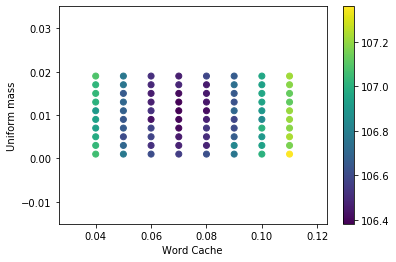

In [16]:
plt.scatter(wcs, uss, c=ppls)
plt.xlabel("Word Cache")
plt.ylabel("Uniform mass")
plt.colorbar()

idx = np.argmin(ppls)
print("Best values", 'cache', wcs[idx], 'unif', uss[idx])

In [20]:
# Tune on decay rate

decays = []
ppls = []

for decay in torch.arange(0.98, .999, 0.001):
    exp.word_cache_pct = .07
    exp.unif_smoothing = .01
    exp.word_cache_decay = decay
    ret = exp.eval_epoch(0)
    int_ppl = ret['val_interp_ppl']
    ppls.append(int_ppl)
    decays.append(decay)
    print(ret)

Evaluating...
Finished batch 0
Partial pred acc - batch acc: 14.000%, pred ppl: 526.1
Targ: <unk> weekend trying to <unk> out new terms    that would be  more acceptable to   the banks </s> after ual the 
Pred: year  of      </s>   to <unk> the of  products </s> the   n't a    <unk>      </s> the <unk> </s> the   the 's  
{'val_loss': 0.03918219901603258, 'val_interp_ppl': 106.89812567179825, 'val_pred_ppl': 117.22550204933934, 'val_pred_acc': 24.260922330097088}
Evaluating...
Finished batch 0
Partial pred acc - batch acc: 14.000%, pred ppl: 517.1
Targ: last month </s> <unk> shares fell   nearly N N  on friday to  close at N N </s> ramada which first 
Pred: </s> week  </s> the   <unk>  closed N      N to to volume the N     at N N </s> the    which has   
{'val_loss': 0.03918567364492897, 'val_interp_ppl': 106.82033783646605, 'val_pred_ppl': 117.21013491958131, 'val_pred_acc': 24.25728155339806}
Evaluating...
Finished batch 0
Partial pred acc - batch acc: 14.000%, pred ppl: 520.7
Targ:

Targ: buying raw land      while avoiding the negative <unk>  to its own   balance sheet mr.  <unk> said </s> the company is 
Pred: the    N   materials </s>  the      the u.s.     impact of the <unk> <unk>   sheet </s> <unk> said </s> the company is 
{'val_loss': 0.039186752507535436, 'val_interp_ppl': 107.2379684851892, 'val_pred_ppl': 117.1961044455846, 'val_pred_acc': 24.266990291262136}
Evaluating...
Finished batch 0
Partial pred acc - batch acc: 13.000%, pred ppl: 589.0
Targ: expand production capacity </s> a   quick     turnaround is crucial  to quantum because its cash  requirements remain heavy </s>   the company 
Pred: N      their      </s>     </s> the spokesman <unk>      in expected to the     's      the <unk> flow         </s>   in    volume the company 
{'val_loss': 0.03918590931701067, 'val_interp_ppl': 107.56778533644885, 'val_pred_ppl': 117.19652486355673, 'val_pred_acc': 24.263349514563107}
Evaluating...
Finished batch 0
Partial pred acc - batch acc: 13.000%, pred 

Best values decay tensor(0.9890)


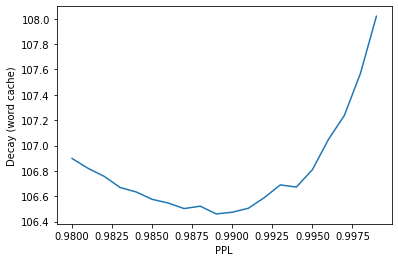

In [21]:
import matplotlib.pyplot as plt
import numpy as np

plt.plot(decays, ppls)
plt.xlabel("PPL")
plt.ylabel("Decay (word cache)")

idx = np.argmin(ppls)
print("Best values", 'decay', decays[idx])

## Tune on KN5 pct

In [ ]:
# Tune on decay rate

kn5_pcts = []
wcs = []
ppls = []

for kn5_pct in torch.arange(0.005, .015, .0025):
    for wc in torch.arange(0.02, .07, .01):
        exp.word_cache_pct = .07
        exp.unif_smoothing = 0
        exp.kn5_pct = kn5_pct
        ret = exp.eval_epoch(0)
        int_ppl = ret['val_interp_ppl']
        wcs.append(wc)
        ppls.append(int_ppl)
        kn5_pcts.append(kn5_pct)
        print(kn5_pct, wc)

Evaluating...
Finished batch 0
Partial pred acc - batch acc: 10.000%, pred ppl: 730.3
Targ: has had in recent years  </s> the ec      and japan the u.s. 's  largest steel      suppliers have n't  been filling 
Pred: is  n't a  the    months </s> the company is  the   's  u.s. and largest securities segment   and  been been <unk>   
tensor(0.0050) tensor(0.0200)
Evaluating...
Finished batch 0
Partial pred acc - batch acc: 10.000%, pred ppl: 758.1
Targ: clobbered two  years ago in   japan when <unk> introduced a powerful detergent called attack which quickly won  a   N     N 
Pred: a         </s> years ago </s> the   </s> the   <unk>      a <unk>    <unk>     for    <unk>  on    has     </s> the <unk> N 
tensor(0.0050) tensor(0.0300)
Evaluating...
Finished batch 0
Partial pred acc - batch acc: 11.000%, pred ppl: 679.4
Targ: and  mrs.  hills </s> many called it  simply a     contrast in styles </s> but some saw it  as a classic 
Pred: </s> <unk> <unk> </s> the  of     the is     <unk> <un

Best values kn5 tensor(0.0100)


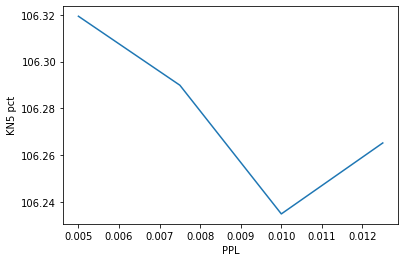

In [42]:

plt.plot(kn5_pcts, ppls)
plt.xlabel("PPL")
plt.ylabel("KN5 pct")

idx = np.argmin(ppls)
print("Best values", 'kn5', kn5_pcts[idx])